In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from matplotlib import pyplot as plt
from skimage.transform import resize
import gc

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

In [3]:
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(factor=(-0.2, 0.2)),
        keras.layers.RandomTranslation(height_factor=(-0.2, 0.2), 
                                       width_factor=(-0.2, 0.2)),
    ]
)

In [4]:
#Pre-proceso las imagenes como me pide inception
x_train = keras.applications.inception_v3.preprocess_input(x_train)
x_test = keras.applications.inception_v3.preprocess_input(x_test)

#Creo los datasets y les hago resizing a tamaño (75, 75, 3)
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

size = (75, 75)
batch_size = 32

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)

test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

In [5]:
x_test.max(), x_test.min()

(1.0, -1.0)

In [17]:
def plot(hist):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11,4))
    ax1.plot(hist.history['loss'], label='CCE')
    ax1.plot(hist.history['val_loss'], label='val_CCE')
    ax1.set_xlabel('Epocas', fontsize=15)
    ax1.set_ylabel('Loss', fontsize=15)
    ax1.legend(loc='best')

    ax2.plot(hist.history['acc'], label='acc')
    ax2.plot(hist.history['val_acc'], label='val_acc')
    ax2.set_xlabel('Epocas', fontsize=15)
    ax2.set_ylabel('Accuracy', fontsize=15)
    ax2.legend(loc='best')

    fig.tight_layout()
    plt.show()
    return None

Vamos a tratar de clasificar el cifar100 utilizando los datos pre-entrenados de\
inception (GoogleNet) haciendo transfer-learning:\
https://keras.io/guides/transfer_learning

In [12]:
#Cargamos el modelo base (Inceptionv3)
base_model = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(75, 75, 3),
)


In [13]:
keras.backend.clear_session()

base_model.trainable = False

inputs = keras.Input(shape=(75, 75, 3))

x = data_augmentation(inputs)

x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.4)(x)  # Regularize with dropout
x = keras.layers.Dense(1000, activation='relu', 
                       kernel_regularizer=keras.regularizers.L2(1e-3))(x)
x = keras.layers.Dropout(0.4)(x)  # Regularize with dropout
outputs = keras.layers.Dense(100, activation='softmax', 
                             kernel_regularizer=keras.regularizers.L2(1e-3))(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 75, 75, 3)         0         
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1000)              2049000   
                                                             

Primero entrenamos la capa densa que agregamos al final

In [14]:
class ClearMemory(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()

def scheduler(epoch, lr):
  if epoch==3 or epoch == 6:
    return lr/3
  else:
    return lr


callbacks_list=[
    keras.callbacks.LearningRateScheduler(
    scheduler, verbose=0
    ),
    ClearMemory(),
    keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5)
]

In [15]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False, name='loss'),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name='acc')],
)

epochs = 10
hist = model.fit(train_ds, epochs=epochs, callbacks=callbacks_list,
                 validation_data=test_ds, verbose=1)


Epoch 1/10
1563/1563 [==============================] - 47s 27ms/step - loss: 4.6280 - acc: 0.1416 - val_loss: 3.7815 - val_acc: 0.2557 - lr: 0.0010
Epoch 2/10
1563/1563 [==============================] - 40s 25ms/step - loss: 4.1585 - acc: 0.1800 - val_loss: 3.6172 - val_acc: 0.2790 - lr: 0.0010
Epoch 3/10
1563/1563 [==============================] - 42s 26ms/step - loss: 4.0774 - acc: 0.1861 - val_loss: 3.5908 - val_acc: 0.2826 - lr: 0.0010
Epoch 4/10
1563/1563 [==============================] - 44s 27ms/step - loss: 3.8326 - acc: 0.2102 - val_loss: 3.2359 - val_acc: 0.3253 - lr: 3.3333e-04
Epoch 5/10
1563/1563 [==============================] - 39s 24ms/step - loss: 3.6798 - acc: 0.2195 - val_loss: 3.1414 - val_acc: 0.3319 - lr: 3.3333e-04
Epoch 6/10
1563/1563 [==============================] - 39s 25ms/step - loss: 3.6183 - acc: 0.2238 - val_loss: 3.0852 - val_acc: 0.3352 - lr: 3.3333e-04
Epoch 7/10
1563/1563 [==============================] - 39s 24ms/step - loss: 3.5233 - acc: 0.

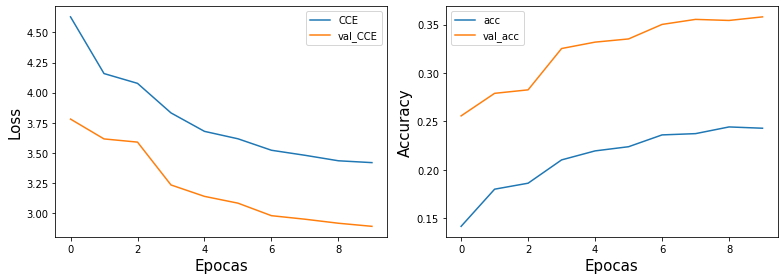

In [18]:
plot(hist)

Y ahora hacemos una pasada a toda la red (fine-tuning)

In [20]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False, name='loss'),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name='acc')],
)

epochs = 10
hist = model.fit(train_ds, epochs=epochs, callbacks=callbacks_list,
                 validation_data=test_ds, verbose=1)


Epoch 1/10
1563/1563 [==============================] - 105s 62ms/step - loss: 2.9029 - acc: 0.3325 - val_loss: 2.1871 - val_acc: 0.4708 - lr: 1.0000e-05
Epoch 2/10
1563/1563 [==============================] - 97s 61ms/step - loss: 2.5755 - acc: 0.3934 - val_loss: 2.0248 - val_acc: 0.5174 - lr: 1.0000e-05
Epoch 3/10
1563/1563 [==============================] - 97s 61ms/step - loss: 2.4096 - acc: 0.4282 - val_loss: 1.8997 - val_acc: 0.5424 - lr: 1.0000e-05
Epoch 4/10
1563/1563 [==============================] - 97s 61ms/step - loss: 2.2620 - acc: 0.4619 - val_loss: 1.8392 - val_acc: 0.5550 - lr: 3.3333e-06
Epoch 5/10
1563/1563 [==============================] - 97s 61ms/step - loss: 2.2175 - acc: 0.4699 - val_loss: 1.8027 - val_acc: 0.5633 - lr: 3.3333e-06
Epoch 6/10
1563/1563 [==============================] - 97s 61ms/step - loss: 2.1821 - acc: 0.4811 - val_loss: 1.7742 - val_acc: 0.5700 - lr: 3.3333e-06
Epoch 7/10
1563/1563 [==============================] - 97s 61ms/step - loss: 2.1

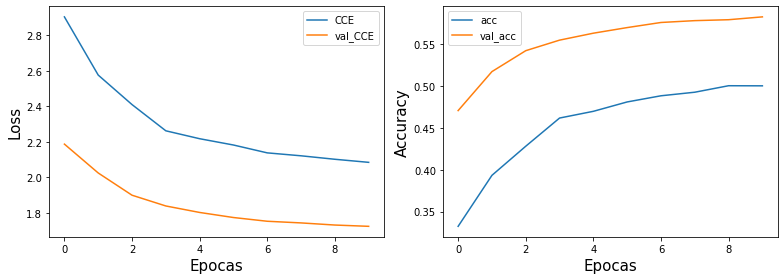

In [21]:
plot(hist)